In [73]:
import pandas as pd
import numpy as np

recalc_everything = True

import altair as alt
print(alt.__version__)
alt.data_transformers.disable_max_rows()
alt.renderers.enable('default')
import altair_saver
import selenium
print(selenium.__version__)

save_figures = True
import vl_convert as vlc
def save_chart(chart_to_save, filename):
    svg_str = vlc.vegalite_to_svg(chart_to_save.to_json())
    with open(filename, "wt") as f:
        f.write(svg_str)

import termcolor
import io
import os

mainstandirname = '../../../Taiwan_Backup/Monkeypox_2022'
os.makedirs(mainstandirname, exist_ok=True)

from IPython.display import Markdown as md

%matplotlib inline
%config matplotlib_inline.matplotlib_formats = 'retina'
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt

# chinese font
from matplotlib import font_manager
fontP = font_manager.FontProperties(fname="./NotoSerifTC-Regular.otf")
fontP.set_size(10)

import pathlib
import platform

import cmdstanpy as cmdstan
import arviz as az
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
standistribdir = '../../../../CmdStan'
cmdstan.set_cmdstan_path(standistribdir[3:] if platform.system()=='Darwin' else standistribdir)

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5),
             "q25": lambda x: np.percentile(x, 25),
             "median": lambda x: np.percentile(x, 50),
             "q75": lambda x: np.percentile(x, 75),
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames, round_to_=5):
    # include mean and hdi
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, round_to=round_to_, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames, rounding=2):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95, round_to=rounding).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50, round_to=rounding).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False, round_to=rounding).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

clrs_ = ["#00a1d5", "#fee391", "#d8daeb", "#bababa", "k"] # via https://nanx.me/ggsci/index.html #blue = #74add1 #yellow = #fee391

num_warmup = 1000
num_iterations = 1250
num_chains = 4

import rpy2.rinterface
%load_ext rpy2.ipython
rpy2.robjects.r['options'](warn=-1)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')
warnings.filterwarnings("ignore", category=RuntimeWarning, module='arviz')
from pytz_deprecation_shim import PytzUsageWarning
warnings.filterwarnings('ignore', category=PytzUsageWarning)

import pyreadr

5.1.1
4.12.0
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [74]:
remote_userID = 'XXX'
remote_userPSW = 'XXX'
remote_IP = 'XXX'
remote_ip = remote_IP

num_warmup = 1000
num_iterations = 1250
num_chains = 4

In [75]:
import pymc as pm
print('Running with PyMC3 version v.{}'.format(pm.__version__))

import pytensor as pt
import pytensor.tensor as tt
from pytensor.compile.ops import as_op
from pytensor import shared

from pymc.pytensorf import collect_default_updates
from pytensor.compile.mode import get_mode

import itertools
import scipy.special as ssp

Running with PyMC3 version v.5.8.1


# Data

In [76]:
date_upper = pd.to_datetime("2023-07-05", format="%Y-%m-%d")
date_lower = date_upper - pd.DateOffset(days = 45)
date_lower

Timestamp('2023-05-21 00:00:00')

In [77]:
mindate = pd.to_datetime("2023-05-15", format="%Y-%m-%d")
mindate_to_show = pd.to_datetime("2023-05-01", format="%Y-%m-%d")
maxdate_to_show = pd.to_datetime("2023-07-20", format="%Y-%m-%d")
cutoff_date = pd.to_datetime("2023-07-15", format="%Y-%m-%d")
truncation_date = pd.to_datetime("2023-08-15", format="%Y-%m-%d")

## A. Loading data from WHO China

In [78]:
!ls ../../data

20230815-China.xlsx
20230823-HongKong-linelist.xlsx
20230823-Taiwan-aggregated-by_confirmation_plus_one_day.csv
20230823-Taiwan-imported.csv
20230823-Taiwan-indigeno.csv
20230907-literature_search.xlsx
20230912-China.xlsx
epicurve_figure_1.csv
lit_search
old
Taiwan
WHO


In [79]:
df = pd.read_excel(os.path.join("../../data", "20230815-China.xlsx"), sheet_name=0).drop('Day', axis=1)
df = df.merge(pd.DataFrame(pd.date_range(df['Date'].min(),truncation_date), columns=['Date']), how='right').fillna(0).set_index('Date').astype('int64').reset_index()
df

,Date,Onset,Diagnosis,Reported
0,2023-01-31,1,0,0
1,2023-02-01,0,0,0
2,2023-02-02,0,0,0
3,2023-02-03,0,0,0
4,2023-02-04,0,0,0
...,...,...,...,...
192,2023-08-11,0,0,0
193,2023-08-12,0,0,0
194,2023-08-13,0,0,0
195,2023-08-14,0,0,0


In [80]:
df_cases = df.copy().drop(['Diagnosis', 'Reported'], axis=1).loc[lambda d: (d.Date>=mindate_to_show)&(d.Date<=maxdate_to_show)]
df_cases

,Date,Onset
90,2023-05-01,0
91,2023-05-02,0
92,2023-05-03,0
93,2023-05-04,0
94,2023-05-05,0
...,...,...
166,2023-07-16,12
167,2023-07-17,17
168,2023-07-18,7
169,2023-07-19,15


## B. Loading Taiwan incidence data from Taiwan CDC

### B.1. By date of symptom onset (as of 23 August 2023)

In [81]:
!ls ../../data/Taiwan/20230823

mpox-centralchanghua-cou.csv  mpox-northernmiaoli-coun.csv
mpox-centralnantou-count.csv  mpox-northerntaoyuan-cit.csv
mpox-centraltaichung-cit.csv  mpox-southernchiayi-city.csv
mpox-easternhualien-coun.csv  mpox-southernchiayi-coun.csv
mpox-easterntaitung-coun.csv  mpox-southerntainan-city.csv
mpox-kaopingkaohsiung-ci.csv  mpox-southernyunlin-coun.csv
mpox-kaopingpenghu-count.csv  mpox-taipeikeelung-city.csv
mpox-kaopingpingtung-cou.csv  mpox-taipeikinmen-county.csv
mpox-nationwide.csv	      mpox-taipeilienchiang-co.csv
mpox-nationwide-imported.csv  mpox-taipeinew-taipei-ci.csv
mpox-nationwide-indigeno.csv  mpox-taipeitaipei-city-i.csv
mpox-northernhsinchu-cit.csv  mpox-taipeiyilan-county.csv
mpox-northernhsinchu-cou.csv


In [82]:
df_twn = pd.read_csv(os.path.join('../../data/Taiwan/20230823', 'mpox-nationwide.csv'), skiprows=1)
df_twn.columns = ['Date', 'Onset_twn']
df_twn['Date'] = [pd.to_datetime(x, format="%Y%m%d") for x in df_twn['Date']]
df_twn

,Date,Onset_twn
0,2022-01-02,0
1,2022-01-03,0
2,2022-01-04,0
3,2022-01-05,0
4,2022-01-06,0
...,...,...
716,2023-12-19,0
717,2023-12-20,0
718,2023-12-21,0
719,2023-12-22,0


In [83]:
df_cases_chn = df_cases.reset_index().merge(df_twn)
df_cases_chn['Onset_chn_hk'] = df_cases_chn['Onset'] - df_cases_chn['Onset_twn']
display(df_cases_chn.loc[lambda d: d.Onset_chn_hk<0])
df_cases_chn = df_cases_chn.loc[lambda d: (d.Date>=mindate) & (d.Date<=maxdate_to_show)]
print("After 1 June 2023:")
df_cases_chn.loc[lambda d: d.Onset_chn_hk<0]

,index,Date,Onset,Onset_twn,Onset_chn_hk
0,90,2023-05-01,0,2,-2
1,91,2023-05-02,0,4,-4
2,92,2023-05-03,0,4,-4
3,93,2023-05-04,0,1,-1
5,95,2023-05-06,0,1,-1
6,96,2023-05-07,1,4,-3
7,97,2023-05-08,0,1,-1
8,98,2023-05-09,0,3,-3
10,100,2023-05-11,0,3,-3
11,101,2023-05-12,0,1,-1


After 1 June 2023:


,index,Date,Onset,Onset_twn,Onset_chn_hk
14,104,2023-05-15,0,4,-4
15,105,2023-05-16,0,3,-3
16,106,2023-05-17,0,3,-3
18,108,2023-05-19,0,6,-6
20,110,2023-05-21,0,1,-1
21,111,2023-05-22,0,2,-2
22,112,2023-05-23,0,2,-2
23,113,2023-05-24,0,1,-1
25,115,2023-05-26,0,2,-2
26,116,2023-05-27,2,3,-1


In [84]:
df_cases_chn['Onset_chn_hk'] = [x if x>0 else 0 for x in df_cases_chn['Onset_chn_hk']]
df_cases_chn['Onset_chn_hk'] = df_cases_chn['Onset_chn_hk'].astype('int64')
df_cases_chn = df_cases_chn.drop(['Onset'], axis=1)
df_cases_chn

,index,Date,Onset_twn,Onset_chn_hk
14,104,2023-05-15,4,0
15,105,2023-05-16,3,0
16,106,2023-05-17,3,0
17,107,2023-05-18,0,0
18,108,2023-05-19,6,0
...,...,...,...,...
76,166,2023-07-16,3,9
77,167,2023-07-17,1,16
78,168,2023-07-18,1,6
79,169,2023-07-19,0,15


### B.2. By date of reporting (= date of confirmation + 1 day)

In [85]:
!ls ../../data/Taiwan/20230901

mpox-nationwide-all-by_confirmation.csv
mpox-nationwide-all-by_notification.csv


In [86]:
df_ = pd.read_csv(os.path.join('../../data/Taiwan/20230901', 'mpox-nationwide-all-by_confirmation.csv'), skiprows=1)
df_.columns = ['Date', 'Reported_twn']
df_['Date'] = [pd.to_datetime(x, format="%Y%m%d") for x in df_['Date']]
df_

,Date,Reported_twn
0,2022-01-02,0
1,2022-01-03,0
2,2022-01-04,0
3,2022-01-05,0
4,2022-01-06,0
...,...,...
694,2023-11-27,0
695,2023-11-28,0
696,2023-11-29,0
697,2023-11-30,0


In [87]:
df_WHO_reported = df.loc[lambda d: d.Reported>0]
df_WHO_reported

,Date,Onset,Diagnosis,Reported
41,2023-03-13,0,0,1
42,2023-03-14,0,0,4
49,2023-03-21,0,0,4
56,2023-03-28,0,0,5
70,2023-04-11,0,0,2
73,2023-04-14,0,0,1
78,2023-04-19,0,0,11
80,2023-04-21,0,0,1
81,2023-04-22,0,0,1
89,2023-04-30,1,0,10


In [88]:
df_WHO_reported = df_WHO_reported.reset_index(drop=True).reset_index()
df_WHO_reported['index'] = df_WHO_reported['index'].fillna(method='bfill')
df_WHO_reported

,index,Date,Onset,Diagnosis,Reported
0,0,2023-03-13,0,0,1
1,1,2023-03-14,0,0,4
2,2,2023-03-21,0,0,4
3,3,2023-03-28,0,0,5
4,4,2023-04-11,0,0,2
5,5,2023-04-14,0,0,1
6,6,2023-04-19,0,0,11
7,7,2023-04-21,0,0,1
8,8,2023-04-22,0,0,1
9,9,2023-04-30,1,0,10


In [89]:
df__ = df_.copy()
df__['Date'] = df__['Date'] + pd.DateOffset(days=1)
df__ = df__.merge(df_WHO_reported.loc[:, ['Date', 'Reported', 'index']], how='left')
df__['index'] = df__['index'].fillna(method='bfill').astype('Int64')
df__ = df__.groupby('index')['Reported_twn'].sum().reset_index().merge(df_WHO_reported, how='left')
df__['Reported_chn_hk'] = df__['Reported'] - df__['Reported_twn']
df__

,index,Reported_twn,Date,Onset,Diagnosis,Reported,Reported_chn_hk
0,0,12,2023-03-13,0,0,1,-11
1,1,0,2023-03-14,0,0,4,4
2,2,4,2023-03-21,0,0,4,0
3,3,5,2023-03-28,0,0,5,0
4,4,4,2023-04-11,0,0,2,-2
5,5,4,2023-04-14,0,0,1,-3
6,6,12,2023-04-19,0,0,11,-1
7,7,4,2023-04-21,0,0,1,-3
8,8,1,2023-04-22,0,0,1,0
9,9,16,2023-04-30,1,0,10,-6


In [90]:
df__.drop('index',axis=1).set_index('Date').to_csv('../../data/20230823-Taiwan-aggregated-by_confirmation_plus_one_day.csv')

In [91]:
df_method2 = df__.loc[:, ['Date', 'Reported_chn_hk']].merge(df, how='right').fillna(0, downcast='infer').loc[lambda d: (d.Date>=mindate)].drop('Reported', axis=1)
df_method2

,Date,Reported_chn_hk,Onset,Diagnosis
104,2023-05-15,0,0,0
105,2023-05-16,2,0,0
106,2023-05-17,0,0,0
107,2023-05-18,0,0,0
108,2023-05-19,0,0,0
...,...,...,...,...
192,2023-08-11,0,0,0
193,2023-08-12,0,0,0
194,2023-08-13,0,0,0
195,2023-08-14,0,0,0


In [92]:
df_cases_method2 = df_cases.merge(df_method2.rename(columns={'Reported_chn_hk':'Reported'}))
df_cases_method2

,Date,Onset,Reported,Diagnosis
0,2023-05-15,0,0,0
1,2023-05-16,0,2,0
2,2023-05-17,0,0,0
3,2023-05-18,0,0,0
4,2023-05-19,0,0,0
...,...,...,...,...
62,2023-07-16,12,0,0
63,2023-07-17,17,0,0
64,2023-07-18,7,0,0
65,2023-07-19,15,0,0


## C. Loading linelist data from Hong Kong

In [93]:
df_linelist_hk = pd.read_excel(os.path.join("../../data", "20230823-HongKong-linelist.xlsx")).drop(['Source', 'Remarks'], axis=1)
df_linelist_hk

,CaseNo,Age,Sex,Comorbidities,Onset,Rash,Diagnosis,Confirmation,Reporting,Exposure
0,1,40,M,N,2023-01-31,2023-02-01,2023-02-01,NaT,2023-02-04,Japan
1,2,34,M,N,2023-04-12,2023-04-12,2023-04-19,NaT,2023-04-20,HK
2,3,25,M,N,2023-04-12,2023-04-12,2023-04-20,2023-04-21,2023-04-21,Korea/Taiwan
3,4,59,M,Y,2023-04-25,2023-04-25,2023-04-27,2023-04-28,2023-04-29,China
4,5,34,M,N,2023-04-30,2023-04-30,2023-04-30,NaT,2023-05-01,Taiwan/HK
5,6,44,M,Y,2023-05-07,NaT,2023-05-09,2023-05-10,2023-05-11,HK
6,7,54,M,Y,2023-06-15,2023-06-15,2023-06-19,2023-06-20,2023-06-21,HK
7,8,48,M,Y,2023-07-02,NaT,2023-07-05,2023-07-06,2023-07-07,HK
8,9,40,M,NaN,2023-07-10,NaT,2023-07-12,2023-07-13,2023-07-13,HK
9,10,20,M,N,2023-07-08,2023-07-10,2023-07-16,2023-07-18,2023-07-18,Japan


In [94]:
df_cases_hk = df_linelist_hk.copy().loc[lambda d: d.Reporting<truncation_date]
df_cases_hk['Cases'] = 1
df_cases_hk = df_cases_hk.groupby('Onset')['Cases'].sum().reset_index().rename(columns={'Onset':'Date', 'Cases':'Onset_hk'})
df_cases_hk

,Date,Onset_hk
0,2023-01-31,1
1,2023-04-12,2
2,2023-04-25,1
3,2023-04-30,1
4,2023-05-07,1
5,2023-06-15,1
6,2023-07-02,1
7,2023-07-08,1
8,2023-07-10,2
9,2023-07-12,1


In [95]:
df_cases_chn_ = df_cases_chn.copy().merge(df_cases_hk, how='left').fillna(0, downcast='infer')
df_cases_chn_method2_ = df_cases_method2.copy().merge(df_cases_hk, how='left').fillna(0, downcast='infer')
df_cases_chn_

,index,Date,Onset_twn,Onset_chn_hk,Onset_hk
0,104,2023-05-15,4,0,0
1,105,2023-05-16,3,0,0
2,106,2023-05-17,3,0,0
3,107,2023-05-18,0,0,0
4,108,2023-05-19,6,0,0
...,...,...,...,...,...
62,166,2023-07-16,3,9,0
63,167,2023-07-17,1,16,1
64,168,2023-07-18,1,6,0
65,169,2023-07-19,0,15,0


In [96]:
df_cases_chn_['Onset'] = df_cases_chn_['Onset_chn_hk'] - df_cases_chn_['Onset_hk']
df_cases_chn_method2_['Onset'] = df_cases_chn_method2_['Onset'] - df_cases_chn_method2_['Onset_hk']
df_cases_chn_.loc[lambda d: d['Onset']<0]

,index,Date,Onset_twn,Onset_chn_hk,Onset_hk,Onset


In [97]:
Df_cases_method1 = df_cases_chn_.copy().drop(['Onset_chn_hk', 'Onset_hk', 'Onset_twn'], axis=1).merge(df.loc[:, ['Date', 'Diagnosis', 'Reported']])
Df_cases_method1

,index,Date,Onset,Diagnosis,Reported
0,104,2023-05-15,0,0,0
1,105,2023-05-16,0,0,12
2,106,2023-05-17,0,0,0
3,107,2023-05-18,0,0,0
4,108,2023-05-19,0,0,0
...,...,...,...,...,...
62,166,2023-07-16,9,0,0
63,167,2023-07-17,15,0,0
64,168,2023-07-18,6,0,0
65,169,2023-07-19,15,0,0


In [98]:
Df_cases_method2 = df_cases_chn_method2_.copy().drop(['Onset_hk'], axis=1)
Df_cases_method2

,Date,Onset,Reported,Diagnosis
0,2023-05-15,0,0,0
1,2023-05-16,0,2,0
2,2023-05-17,0,0,0
3,2023-05-18,0,0,0
4,2023-05-19,0,0,0
...,...,...,...,...
62,2023-07-16,12,0,0
63,2023-07-17,16,0,0
64,2023-07-18,7,0,0
65,2023-07-19,15,0,0


In [99]:
Df_cases_method2.to_csv('../../data/epicurve_figure_1.csv', index=False)

In [100]:
Df_cases_method2.loc[lambda d: d.Onset==Df_cases_method2.Onset.max()]

,Date,Onset,Reported,Diagnosis
51,2023-07-05,21,0,0
55,2023-07-09,21,0,1


In [101]:
clrs_ = ["#00a1d5", "#fee391", "#d8daeb", "#bababa", "k"]
colors = ['#4575b4', '#fdae61']
Df_cases_ = Df_cases_method2

base = alt.Chart(Df_cases_).encode(
    alt.X('Date', axis=alt.Axis(title="Date of symptom onset (month/day in 2023)", format = ("%m/%d")), 
          scale=alt.Scale(domain=[mindate, maxdate_to_show]))
)

ymx = 23; Rtmax=8
bar_cases_obs = base.mark_area(interpolate='step-before', color=clrs_[0], binSpacing=0, width=5.25, clip=True).encode(
    alt.Y('Onset:Q', scale=alt.Scale(domain=[0, ymx]), sort=['local', 'imported'][::-1])
)

chart = alt.layer(bar_cases_obs).configure_range(
        category=alt.RangeScheme(clrs_)
).resolve_scale(y = 'independent').properties(width=400, height=300).configure_axis(grid=False)

# save_chart(chart, f'figures/{basename}.svg')

chart

alt.LayerChart(...)

In [32]:
# mindate is the day number 1
Tupper_ = (date_upper-mindate).days + 1
Tupper_

52

In [33]:
# mindate is the day number 1
Tlower_ = (date_lower-mindate).days + 1
Tlower_

7

In [34]:
# overall
df.drop('Date', axis=1).sum(axis=0)

Onset        615
Diagnosis     19
Reported     225
dtype: int64

In [35]:
df_twn.drop('Date', axis=1).sum(axis=0)

Onset_twn    292
dtype: int64

In [36]:
# mindate is the day number 1
TJul1_ = (pd.to_datetime('2023-07-01')-mindate).days + 1
TAug1_ = (pd.to_datetime('2023-08-01')-mindate).days + 1
TSep1_ = (pd.to_datetime('2023-09-01')-mindate).days + 1
[TJul1_, TAug1_, TSep1_]

[48, 79, 110]

In [37]:
df_cases_ = df_cases.loc[lambda d: d['Date']>=mindate].reset_index(drop=True).reset_index()
df_cases_['index'] += 1
df_cases_.loc[lambda d: d['index']>=Tlower_]

,index,Date,Onset
6,7,2023-05-21,0
7,8,2023-05-22,0
8,9,2023-05-23,0
9,10,2023-05-24,0
10,11,2023-05-25,2
...,...,...,...
62,63,2023-07-16,12
63,64,2023-07-17,17
64,65,2023-07-18,7
65,66,2023-07-19,15


In [38]:
df.loc[lambda d: (d.Date>=pd.to_datetime('2023-07-01'))&(d.Date<pd.to_datetime('2023-08-01'))].drop('Date', axis=1).sum(axis=0)

Onset        370
Diagnosis     11
Reported      34
dtype: int64

In [39]:
370+491+11-df_twn.loc[lambda d: (d.Date>=pd.to_datetime('2023-07-01'))&(d.Date<pd.to_datetime('2023-08-01'))].drop('Date',axis=1).sum(axis=0).values[0]

834

In [40]:
df.loc[lambda d: (d.Date>=Df_cases_method1.Date.min())&(d.Date<=Df_cases_method1.Date.max())].drop('Date',axis=1).sum(axis=0)

Onset        532
Diagnosis      9
Reported     158
dtype: int64

In [41]:
df.loc[lambda d: (d.Date>=Df_cases_method1.Date.min())&(d.Date<=Df_cases_method1.Date.max())].drop('Date',axis=1).sum(axis=0).sum()

699

In [42]:
df_twn.loc[lambda d: (d.Date>=Df_cases_method1.Date.min())&(d.Date<=Df_cases_method1.Date.max())].drop('Date',axis=1).sum(axis=0)

Onset_twn    144
dtype: int64

In [43]:
Df_cases_method2.drop('Date', axis=1).sum(axis=0)

Onset        524
Reported       7
Diagnosis      9
dtype: int64

In [44]:
Df_cases_method2.drop('Date', axis=1).sum(axis=0).sum()

540

In [45]:
Df_cases_method1.drop(['Date','index'], axis=1).sum(axis=0)

Onset        414
Diagnosis      9
Reported     158
dtype: int64

In [46]:
Df_cases_method1.drop(['Date', 'index'], axis=1).sum(axis=0).sum()

581

# <font color="green">2. Analysis</font>

## <font color="orange">2a. Identifying the reporting delay from HK data</font>

In [47]:
stan_code_delay_gengamma = """functions {
    real gengammaloc(real q, real sigma, real mean) {
        real a = inv_square(q), cinv = sigma / q,
            value = lgamma(a + cinv) - lgamma(a) - log(a) * cinv;
            
        return log(mean) - value;
    }

    real gengammamean(real q, real mu, real sigma) {
        real a = inv_square(q), cinv = sigma / q,
            value = lgamma(a + cinv) - lgamma(a) - log(a) * cinv;

        return exp(mu + value);
    }

    real gengammacv(real q, real mu, real sigma) {
        real a = inv_square(q), cinv = sigma / q,
            value = lgamma(a) + lgamma(2*cinv + a) - 2 * lgamma(cinv + a); 

        return sqrt(expm1(value));
    }
    
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    real gengamma_cdf(vector x, real q, real mu, real sigma) {
        int N = size(x);
        vector[N] logx = log(x),
            z = (logx - mu) / sigma;
        real a = inv_square(q),
            value = gamma_cdf(a * exp(q .* z) | a, 1);

        return value;
    }
}

data {
    int<lower = 1> T; // truncation date
    int<lower = 1> N; // number of records
    array[N] int<upper = T> onset_L;
    array[N] int<lower = onset_L, upper = T> confirmation_L;
}

transformed data {
    vector[N] confirmation_L_vec = to_vector(confirmation_L), onset_L_vec = to_vector(onset_L);

    int L = 2;
}

parameters {
    vector<lower = 0, upper = 1>[N] onset_raw, confirmation_raw;
    
    real loga, logsigma, mu;
    simplex[L] weight;
}

transformed parameters {
    real a = exp(loga), q = inv_sqrt(a), sigma = exp(logsigma);
    vector[L] lps = log(weight);
    {
        vector[N] confirmation = confirmation_L_vec + confirmation_raw, onset;
        for (i in 1:N) {
            onset[i] = (onset_L[i] == confirmation_L[i]) ? fma(confirmation[i] - onset_L[i], onset_raw[i], onset_L[i]) : 
                onset_L[i] + onset_raw[i];
        }
        vector[N] x = confirmation - onset, X = T - onset + 1;
    
        for (comp in 1:2) {
            if (comp==1) {
                real logq = log(q);
                vector[N] logx = log(x), logX = log(X),
                    z = (logx - mu) / sigma, Z = (logX - mu) / sigma,
                    y = a * exp(q * z), Y = a * exp(q * Z);
                lps[comp] = gamma_lpdf(y | a, 1) - gamma_lcdf(Y | a, 1);
                // jacobian
                lps[comp] += sum(q * z) - N * logsigma - N * log(q);
            } else {
                lps[comp] = lognormal_lpdf(x | mu, sigma) - lognormal_lcdf(X | mu, sigma);
            }
        }
    }
}

model {
    /* priors */
    loga ~ std_normal();
    logsigma ~ normal(-1, 2);
    mu ~ std_normal();

    target += log_sum_exp(lps);
}

generated quantities {
    vector<lower = 0, upper = 1>[L] prob = exp(lps - log_sum_exp(lps));
    int comp = categorical_rng(prob);

    real mean_delay, sd_delay;

    if (comp==1) {
        mean_delay = gengammamean(q, mu, sigma);
        sd_delay = mean_delay * gengammacv(q, mu, sigma);
    } else {
        mean_delay = exp(mu + square(sigma) / 2.0);
        sd_delay = mean_delay * exp(square(sigma) - 1.0);
    }
}"""

In [48]:
truncation_date_hk = pd.to_datetime('2023-08-23')

In [49]:
df_linelist_hk[:4]

,CaseNo,Age,Sex,Comorbidities,Onset,Rash,Diagnosis,Confirmation,Reporting,Exposure
0,1,40,M,N,2023-01-31,2023-02-01,2023-02-01,NaT,2023-02-04,Japan
1,2,34,M,N,2023-04-12,2023-04-12,2023-04-19,NaT,2023-04-20,HK
2,3,25,M,N,2023-04-12,2023-04-12,2023-04-20,2023-04-21,2023-04-21,Korea/Taiwan
3,4,59,M,Y,2023-04-25,2023-04-25,2023-04-27,2023-04-28,2023-04-29,China


In [50]:
if recalc_everything:
    for by_diagnosis_ in [False, True]:
        basename = truncation_date_hk.strftime("%Y%m%d")+f'_reporting_delay_HK_gengamma'
        if by_diagnosis_:
            basename += '-diangosis'
        standirname = os.path.join(mainstandirname, basename)
        
        !rm {standirname}/*
        os.makedirs(standirname, exist_ok=True)
    
        stanscriptdir = '../Dropbox/'+standirname[9:]
        col = 'Diagnosis' if by_diagnosis_ else 'Reporting' 
    
        df_ = df_linelist_hk.loc[lambda d: (~pd.isnull(d.Onset)) & (~pd.isnull(d[col]))].copy()
        df_['Onset_day'] = (df_['Onset'] - mindate).dt.days
        df_['Notification_day'] = (df_[col] - mindate).dt.days
        truncation_day = (truncation_date_hk - mindate).days + 1
        
        stan_data = dict({
            'T': truncation_day,
            'onset_L': np.array(df_.Onset_day.values, dtype='int64'),
            'confirmation_L': np.array(df_.Notification_day.values, dtype='int64'),
            'N': df_.shape[0]
        })
        stan_data_file = os.path.join(standirname, 'Data.json')
        cmdstan.write_stan_json(stan_data_file, stan_data)
    
        stan_inits = dict({
            'mean_delay': 2.5,
            'q': 1.0,
            'sigma': 1.0
        })
        stan_init_file = os.path.join(standirname, 'Inits.json')
        cmdstan.write_stan_json(stan_init_file, stan_inits)
    
        stan_code_file = os.path.join(standirname, f'fit_delay_gengamma.stan')
        with open(stan_code_file, "w+") as f:
            exec(f'f.write(stan_code_delay_gengamma)')
            f.close()
        
        stanscriptdir = '../Dropbox/'+standirname[9:]
        bash_file = f"""#!/bin/bash
cwd=$(pwd)
cd {standistribdir}
make -j4 {stanscriptdir}/fit_delay_gengamma
cd {stanscriptdir}
mkdir -p diagnostics
for i in {{1..{num_chains}}}
do
    echo Running ${{i}}
    SEEDNUMBER=$((18+$i))
    ./fit_delay_gengamma \\
        method=sample num_samples={num_iterations} num_warmup={int(num_warmup)} thin=1 save_warmup=0 adapt delta=0.98 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${{SEEDNUMBER}} \\
        id=$i \\
        data file=Data.json \\
        init=Inits.json \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics-$i.csv > output-$i.txt &
done
echo Finished haha!
"""
        with open(os.path.join(standirname, "fit_bash.sh"), "w+") as f:
            f.write(bash_file)
            f.close()
    
        fls = !ls -p {standirname} | grep -v /
        for fl in fls:
            print(fl)
            !curl -sS --insecure --ftp-create-dirs --user {remote_userID}:{remote_userPSW} -T {standirname}/{fl} sftp://{remote_IP}/home/andrei/Dropbox/{standirname[9:]}/{fl}
            
        !sshpass -p {remote_userPSW} ssh {remote_userID}@{remote_IP} -n -f "sh -c 'cd Dropbox/{standirname[9:]}; rm fit_delay_gengamma; bash --login -s < fit_bash.sh' >/dev/null 2>&1 </dev/null &"

Data.json
fit_bash.sh
fit_delay_gengamma.stan
Inits.json
Data.json
fit_bash.sh
fit_delay_gengamma.stan
Inits.json


### By reporting date

In [51]:
basename = truncation_date_hk.strftime("%Y%m%d")+f'_reporting_delay_HK_gengamma'
standirname = os.path.join(mainstandirname, basename)

In [52]:
fls = !sshpass -p {remote_userPSW} ssh {remote_userID}@{remote_IP} -n -f "sh -c 'cd Dropbox/{standirname[9:]}; ls -p ' | grep -v / "
for fl in [fl for fl in fls if ('.csv' in fl) | ('.txt' in fl)]:
    print(fl)
    !curl -sS --insecure --user {remote_userID}:{remote_userPSW} --output-dir {standirname} -O sftp://{remote_IP}/home/andrei/Dropbox/{standirname[9:]}/{fl} 

diagnostics-1.csv
diagnostics-2.csv
diagnostics-3.csv
diagnostics-4.csv
output-1.txt
output-2.txt
output-3.txt
output-4.txt
trace-1.csv
trace-2.csv
trace-3.csv
trace-4.csv


['../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-2.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-3.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-4.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma/trace-1.csv']


,Parameter,Mean (95% CI)
0,"Mean delay, days","5.97 (5.05, 7.00)"
1,"SD, days","2.72 (2.12, 3.66)"
2,a,"1.32 (0.25, 4.70)"
3,sigma,"0.42 (0.29, 0.58)"
4,mu,"1.91 (1.70, 2.13)"
5,q,"1.07 (0.46, 2.01)"
6,loga,"-0.01 (-1.39, 1.55)"
7,logsigma,"-0.89 (-1.25, -0.54)"


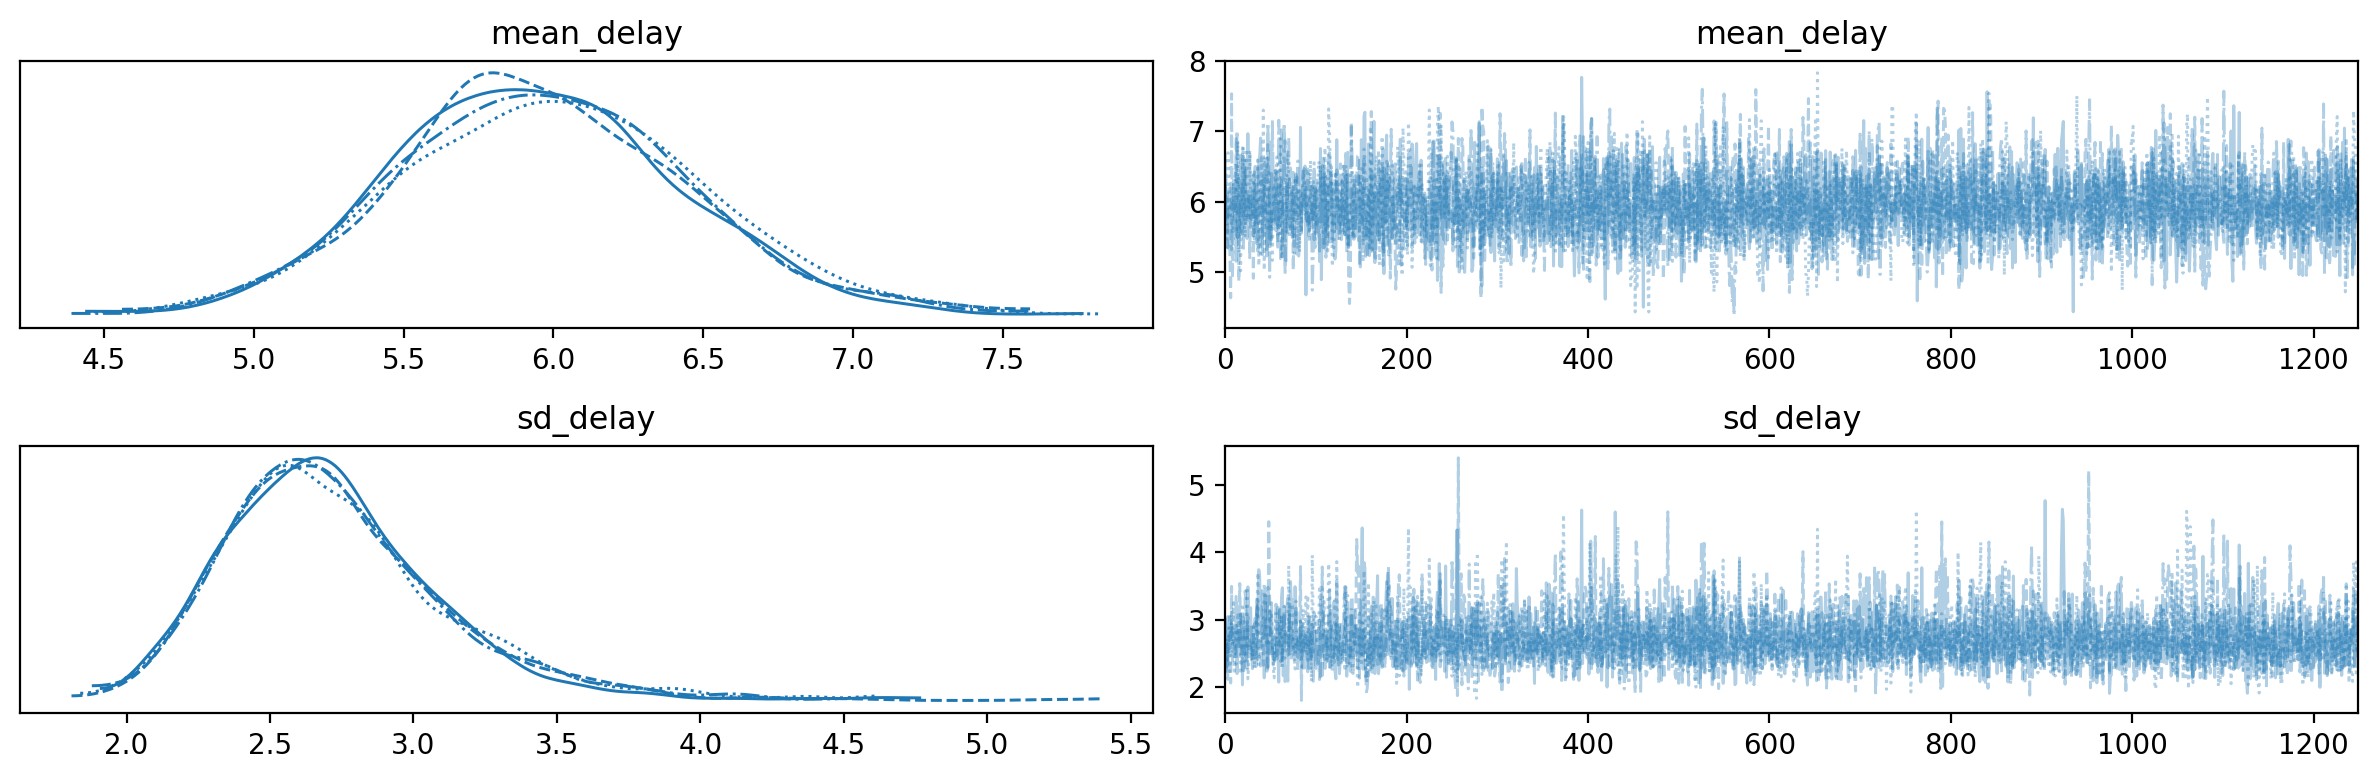

In [53]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
fit_rep_delay = cmdstan.from_csv(paths)

idata_rep_delay = az.from_cmdstanpy(posterior=fit_rep_delay)

mod_delay_summary_output = get_stats(idata_rep_delay.posterior, ['mean_delay', 'sd_delay', 'a', 'sigma', 'mu', 'q', 'loga', 'logsigma'])
mod_delay_summary_output['var'] = mod_delay_summary_output['var'].astype('string')
for col in mod_delay_summary_output.columns[2:]:
    mod_delay_summary_output[col] = mod_delay_summary_output[col].astype('float')
mod_delay_summary_output['Mean (95% CI)'] = ["%.2f (%.2f, %.2f)" % (x, y, z) for (x,y,z) in zip(mod_delay_summary_output['mean'], mod_delay_summary_output['q2.5'], mod_delay_summary_output['q97.5'])]
mod_delay_summary_output['Parameter'] = ['Mean delay, days','SD, days','a', 'sigma', 'mu', 'q', 'loga', 'logsigma'] 

az.plot_trace(idata_rep_delay, var_names=('mean_delay', 'sd_delay')); plt.tight_layout()
mod_delay_summary = az.summary(idata_rep_delay, var_names=['mean_delay', 'sd_delay'], hdi_prob=0.95)

display(mod_delay_summary_output.loc[:, ['Parameter', 'Mean (95% CI)']])

In [54]:
stats_summary_rep_delay = az.summary(idata_rep_delay, ['mu', 'loga', 'logsigma'])
stats_summary_rep_delay

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.911,0.109,1.717,2.122,0.001,0.001,6378.0,3739.0,1.0
loga,-0.010,0.737,-1.402,1.391,0.010,0.009,5914.0,3920.0,1.0
logsigma,-0.887,0.181,-1.230,-0.556,0.003,0.002,5190.0,4025.0,1.0


### By diagnosis date

In [55]:
basename = truncation_date_hk.strftime("%Y%m%d")+f'_reporting_delay_HK_gengamma-diangosis'
standirname = os.path.join(mainstandirname, basename)

In [56]:
fls = !sshpass -p {remote_userPSW} ssh {remote_userID}@{remote_IP} -n -f "sh -c 'cd Dropbox/{standirname[9:]}; ls -p ' | grep -v / "
for fl in [fl for fl in fls if ('.csv' in fl) | ('.txt' in fl)]:
    print(fl)
    !curl -sS --insecure --user {remote_userID}:{remote_userPSW} --output-dir {standirname} -O sftp://{remote_IP}/home/andrei/Dropbox/{standirname[9:]}/{fl} 

diagnostics-1.csv
diagnostics-2.csv
diagnostics-3.csv
diagnostics-4.csv
output-1.txt
output-2.txt
output-3.txt
output-4.txt
trace-1.csv
trace-2.csv
trace-3.csv
trace-4.csv


['../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-2.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-3.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-4.csv', '../../../Taiwan_Backup/Monkeypox_2022/20230823_reporting_delay_HK_gengamma-diangosis/trace-1.csv']


,Parameter,Mean (95% CI)
0,"Mean delay, days","3.44 (2.65, 4.44)"
1,"SD, days","2.47 (1.81, 3.84)"
2,a,"1.27 (0.18, 5.21)"
3,sigma,"0.68 (0.42, 0.98)"
4,mu,"1.36 (0.97, 1.75)"
5,q,"1.17 (0.44, 2.33)"
6,loga,"-0.14 (-1.69, 1.65)"
7,logsigma,"-0.41 (-0.86, -0.02)"


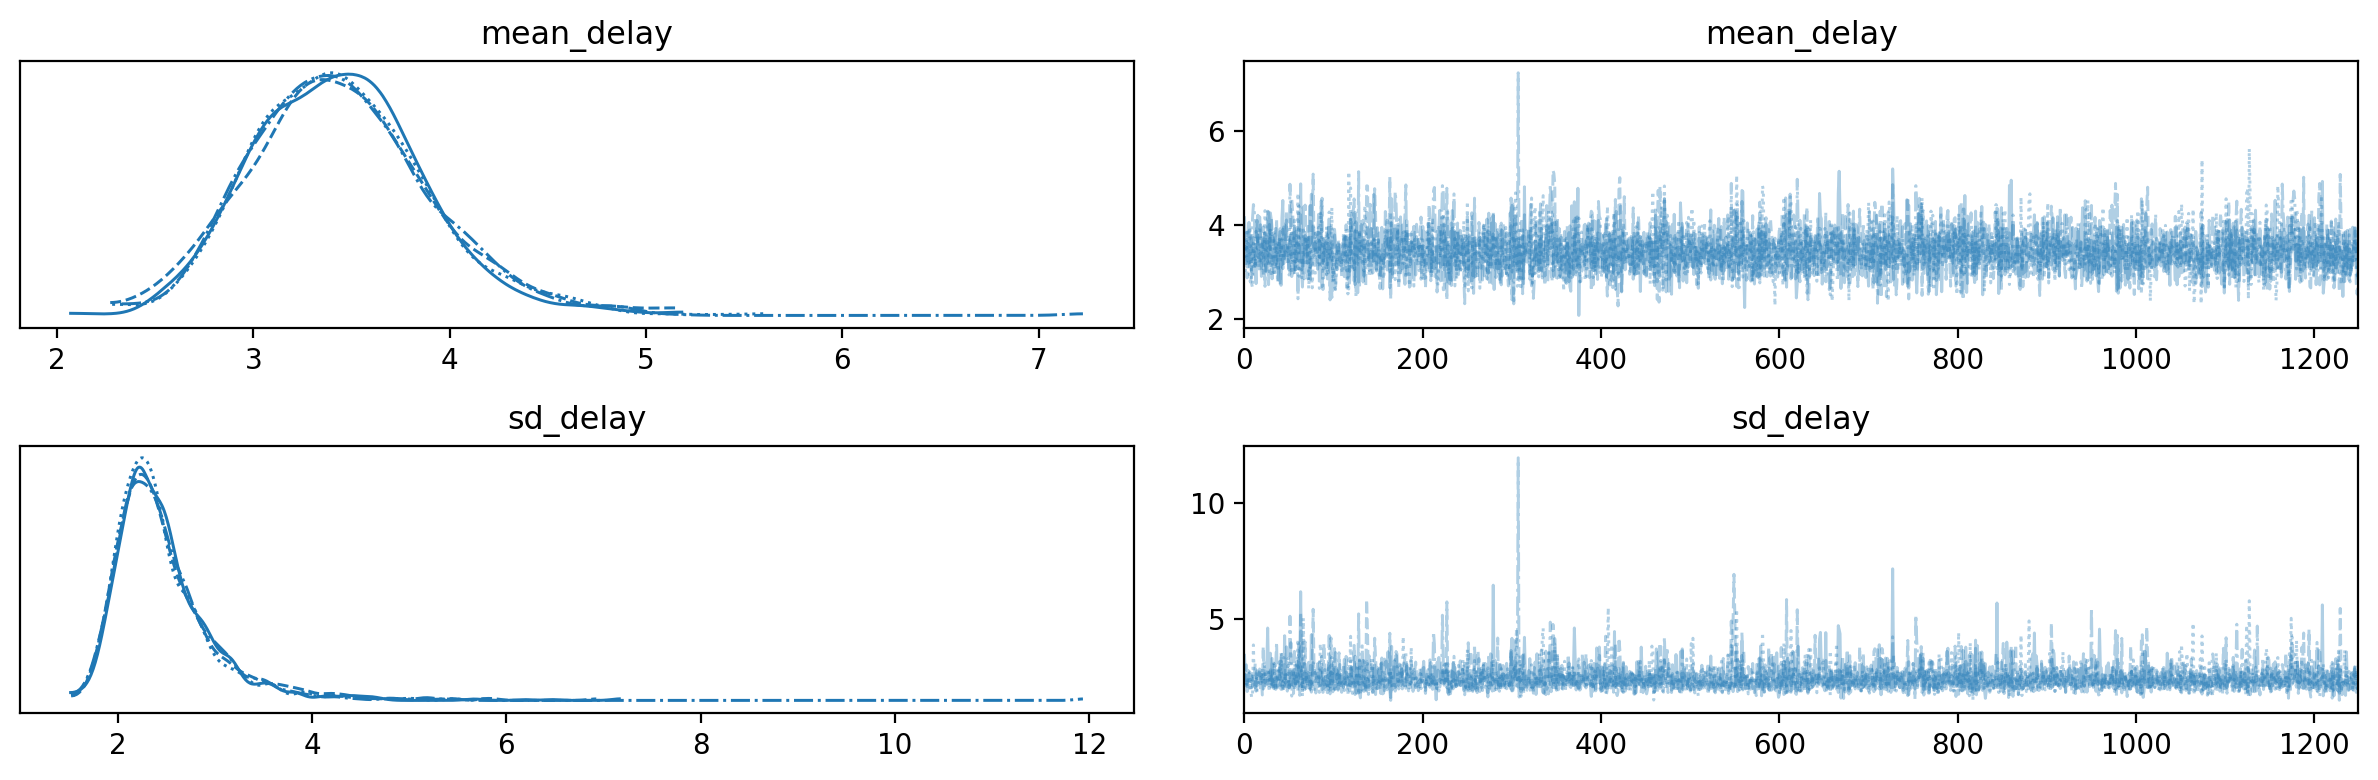

In [57]:
paths = [str(x) for x in list(pathlib.Path(standirname).glob("trace*.csv"))]
print(paths)
fit_rep_delay_diagnosis = cmdstan.from_csv(paths)

idata_rep_delay_diagnosis = az.from_cmdstanpy(posterior=fit_rep_delay_diagnosis)

mod_delay_diagnosis_summary_output = get_stats(idata_rep_delay_diagnosis.posterior, ['mean_delay', 'sd_delay', 'a', 'sigma', 'mu', 'q', 'loga', 'logsigma'])
mod_delay_diagnosis_summary_output['var'] = mod_delay_diagnosis_summary_output['var'].astype('string')
for col in mod_delay_diagnosis_summary_output.columns[2:]:
    mod_delay_diagnosis_summary_output[col] = mod_delay_diagnosis_summary_output[col].astype('float')
mod_delay_diagnosis_summary_output['Mean (95% CI)'] = ["%.2f (%.2f, %.2f)" % (x, y, z) for (x,y,z) in zip(mod_delay_diagnosis_summary_output['mean'], mod_delay_diagnosis_summary_output['q2.5'], mod_delay_diagnosis_summary_output['q97.5'])]
mod_delay_diagnosis_summary_output['Parameter'] = ['Mean delay, days','SD, days','a', 'sigma', 'mu', 'q', 'loga', 'logsigma'] 

az.plot_trace(idata_rep_delay_diagnosis, var_names=('mean_delay', 'sd_delay')); plt.tight_layout()
mod_delay_diagnosis_summary = az.summary(idata_rep_delay_diagnosis, var_names=['mean_delay', 'sd_delay'], hdi_prob=0.95)

display(mod_delay_diagnosis_summary_output.loc[:, ['Parameter', 'Mean (95% CI)']])

In [58]:
stats_summary_rep_delay_diagnosis = az.summary(idata_rep_delay_diagnosis, ['mu', 'loga', 'logsigma'])
stats_summary_rep_delay_diagnosis

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.357,0.195,0.990,1.729,0.003,0.002,4979.0,3487.0,1.0
loga,-0.137,0.838,-1.701,1.456,0.012,0.011,4705.0,3503.0,1.0
logsigma,-0.410,0.207,-0.778,-0.001,0.003,0.002,4755.0,3145.0,1.0


## <font color="orange">2b. Estimating the R0 in Mainland China</font>

In [59]:
stan_code_exp_growth = """functions {
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    /* discretized version */
    vector dgengamma(real q, real mu, real sigma, int D) {
        vector[D] res;
        for (k in 1:D)
            res[k] = gengamma_cdf(k - 0.5 | q, mu, sigma);

        if (D > 1)
            return append_row(append_row(res[1], tail(res, D-1) - head(res, D-1)), 1.0 - res[D]);
        else 
            return to_vector({res[1], 1 - res[1]});
    }

    vector dgamma(real param1, real param2, int K) {
        vector[K] res;
        for (k in 1:K)
            res[k] = gamma_cdf(k - 0.5 | param1, param2);

        return append_row(res[1], tail(res, K-1) - head(res, K-1));
    }
}

data {
    int<lower = 1> Tlower, Tupper; // the cutoffday for the estimation of the exponential growth 
    array[Tupper] int<lower = 0> cases_onset; // number of cases by date of symptom onset starting to be recorded till the day Tupper

    int<lower = Tupper> T; // total number of days for which we have the data on number of cases by date of notification (their symptom onset date is missed)
    array[T] int<lower = 0> cases_reported, cases_diagnosis;

    int<lower = Tupper> Tpred;
    int<upper = Tpred> TJul1, TAug1, TSep1;

    // reporting delay described by the generalized gamma distribution
    real loga, logsigma, mu;

    // delay b/w onset and diagnosis described by the generalized gamma distribution
    real loga_diagnosis, logsigma_diagnosis, mu_diagnosis;

    // generation time (scale and shape of the Gamma distribution estimated in Guzetta et al. 2022)
    real<lower = 0> genalpha, geninvbeta;
}

transformed data {
    // reporting delay
    real a = exp(loga), q = inv_sqrt(a), sigma = exp(logsigma);

    // delay b/w onset and diagnosis
    real a_diagnosis = exp(loga_diagnosis), q_diagnosis = inv_sqrt(a_diagnosis), sigma_diagnosis = exp(logsigma_diagnosis);

    // generation time
    real genmean = genalpha * geninvbeta,
        gensigma = sqrt(genalpha) * geninvbeta;

    vector[Tupper] gent = dgamma(genalpha, 1.0 / geninvbeta, Tupper),
          gent_rev = reverse(gent);

    // backprojecting from the reporting date
    array[T] int cases_onset_backprj = rep_array(0, T);
    for (t in 1:T) 
        if (cases_reported[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q, mu, sigma, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_reported[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }

    // backprojecting from the diagnosis date
    for (t in 1:T) 
        if (cases_diagnosis[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q_diagnosis, mu_diagnosis, sigma_diagnosis, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_diagnosis[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }


    array[Tupper] int cases;
    for (t in 1:Tupper) 
        cases[t] = cases_onset[t] + cases_onset_backprj[t];

    real jitter = 1e-9;
}

parameters {
    // exponential growth rate
    real logr;
    // initial incidence
    real<lower = 0> i0;
    // process error
    real<lower = 0> phi;
}

transformed parameters {
    real r = exp(logr);
}

model {
    logr ~ std_normal();
    i0 ~ normal(5, 10);
    phi ~ gamma(1, 1);

    for (t in Tlower:Tupper)
        if (cases[t] > 0)
            target += neg_binomial_2_lupmf(cases[t] | i0 * exp(r * t) + jitter, phi); 
}

generated quantities {
    // basic reproduction number
    real R0 = exp(r * genmean - 0.5 * square(r) * square(gensigma));

    // doubling time
    real doubling_time = log(2) / r; 

    array[Tpred] int cases_prj = rep_array(0, Tpred);
    for (t in 1:Tpred)
        cases_prj[t] = (t > Tupper) ? neg_binomial_2_rng(i0 * exp(r * t), phi) : cases[t];

    int casesJul = sum(cases_prj[TJul1:TAug1-1]), 
        casesAug = sum(cases_prj[TAug1:TSep1-1]);

    array[Tpred] int cases_reported_prj = rep_array(0, Tpred);
    for (t in 1:Tpred) 
        if (cases_prj[t] > 0) {
            vector[Tpred-t+2] probs_for_prj = dgengamma(q, mu, sigma, Tpred-t+1);
            array[Tpred-t+2] int counts = multinomial_rng(probs_for_prj, cases_prj[t]);
            for (s in 1:Tpred-t+1)
                cases_reported_prj[t+s-1] += counts[s];
        }

    int reportedJul = sum(cases_reported_prj[TJul1:TAug1-1]), 
        reportedAug = sum(cases_reported_prj[TAug1:TSep1-1]);
}"""

### Data decomposition

In [ ]:
%%time
if recalc_everything:
    basename = truncation_date_hk.strftime("%Y%m%d")+f'_exp_growth_China_method2'
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]

    Df_ = Df_cases_method2

    stan_data = dict({
        'Tupper': Tupper_,
        'Tlower': Tlower_,
        'Tpred': TSep1_ + 1,
        'TJul1': TJul1_,
        'TAug1': TAug1_,
        'TSep1': TSep1_,
        'cases_onset': Df_['Onset'].astype('int64').values[:Tupper_],
        'T': Df_.shape[0],
        'cases_reported': Df_['Reported'].astype('int64').values,
        'loga': stats_summary_rep_delay.loc['loga']['mean'],
        'logsigma': stats_summary_rep_delay.loc['logsigma']['mean'],
        'mu': stats_summary_rep_delay.loc['mu']['mean'],
        'cases_diagnosis': Df_['Diagnosis'].astype('int64').values,
        'loga_diagnosis': stats_summary_rep_delay_diagnosis.loc['loga']['mean'],
        'logsigma_diagnosis': stats_summary_rep_delay_diagnosis.loc['logsigma']['mean'],
        'mu_diagnosis': stats_summary_rep_delay_diagnosis.loc['mu']['mean'],
        'genalpha': 4.85,
        'geninvbeta': 2.57
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    stan_inits = dict({
        'r': 0.1,
        'phi': 1.0
    })
    stan_init_file = os.path.join(standirname, 'Inits.json')
    cmdstan.write_stan_json(stan_init_file, stan_inits)

    stan_code_file = os.path.join(standirname, f'fit_exp_growth.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_exp_growth)
        f.close()
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file, cpp_options={'STAN_THREADS': 'TRUE'}, compile='force')
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1, inits=stan_init_file, parallel_chains=10,
                       show_console=False, show_progress=False, chains = 4000)
    fit.save_csvfiles(dir=standirname)

In [61]:
idata_chn_method2 = az.from_cmdstanpy(posterior=fit)
df_stats_chn_method2 = get_stats(idata_chn_method2.posterior, ['r', 'i0', 'phi', 'R0', 'doubling_time']) 
df_stats_chn_method2

arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,r,NA,0.04829,0.03290,0.04314,0.05279,0.06217,0.03368,0.04333,0.04821,0.05311,0.06308,NaN,NaN,NaN
1,i0,NA,1.51443,0.82207,1.15463,1.66496,2.44224,0.85043,1.21805,1.45984,1.75387,2.48244,NaN,NaN,NaN
2,phi,NA,6.77518,3.24767,4.72159,7.19394,10.76980,3.54909,5.35906,6.50782,7.94861,11.35514,NaN,NaN,NaN
3,R0,NA,1.76277,1.47854,1.66181,1.84663,2.03773,1.49431,1.66540,1.75711,1.85291,2.05969,NaN,NaN,NaN
4,doubling_time,NA,14.71556,10.56310,12.45800,15.21350,19.78310,10.98796,13.05238,14.37820,15.99535,20.57868,NaN,NaN,NaN


In [62]:
get_stats(idata_chn_method2, ['casesJul', 'casesAug']) 

arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,casesJul,NA,1076.2485,608.0,829.0,1158.0,1635.0,652.950,885.0,1036.0,1224.25,1724.0,NaN,NaN,NaN
1,casesAug,NA,5198.1565,1300.0,2508.0,5197.0,10346.0,1819.625,3370.0,4614.5,6297.00,12058.0,NaN,NaN,NaN


In [63]:
get_stats(idata_chn_method2, ['reportedJul', 'reportedAug']) 

arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (4000, 1), minimum_shape: (chains=1, draws=4)


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,reportedJul,NA,801.45125,514.0,651.0,850.0,1129.0,542.975,686.0,780.0,894.0,1184.05,NaN,NaN,NaN
1,reportedAug,NA,3852.77850,1043.0,2250.0,4118.0,7273.0,1491.950,2612.0,3492.5,4637.0,8291.15,NaN,NaN,NaN


## <font color="orange">C. Global trends in 2022</font>

In [104]:
stan_code_exp_growth_global = """functions {
    real gengamma_cdf(real x, real q, real mu, real sigma) {
        real logx = log(x),
            z = (logx - mu) / sigma,
            a = inv_square(q),
            value = gamma_cdf(a * exp(q * z) | a, 1);

        return value;
    }

    /* discretized version */
    vector dgengamma(real q, real mu, real sigma, int D) {
        vector[D] res;
        for (k in 1:D)
            res[k] = gengamma_cdf(k - 0.5 | q, mu, sigma);

        if (D > 1)
            return append_row(append_row(res[1], tail(res, D-1) - head(res, D-1)), 1.0 - res[D]);
        else 
            return to_vector({res[1], 1 - res[1]});
    }

    vector dgamma(real param1, real param2, int K) {
        vector[K] res;
        for (k in 1:K)
            res[k] = gamma_cdf(k - 0.5 | param1, param2);

        return append_row(res[1], tail(res, K-1) - head(res, K-1));
    }
}

data {
    int<lower = 1> Tupper; // the cutoffday for the estimation of the exponential growth 
    array[Tupper] int<lower = 0> cases_onset; // number of cases by date of symptom onset starting to be recorded till the day Tupper

    int<lower = Tupper> T; // total number of days for which we have the data on number of cases by day of notification (their symptom onset date is missed)
    array[T] int<lower = 0> cases_reported, cases_diagnosis;

    // reporting delay described by the generalized gamma distribution
    real loga, logsigma, mu;

    // delay b/w onset and diagnosis described by the generalized gamma distribution
    real loga_diagnosis, logsigma_diagnosis, mu_diagnosis;

    // generation time (scale and shape of the Gamma distribution estimated in Guzetta et al. 2022)
    real<lower = 0> genalpha, geninvbeta;
}

transformed data {
    // reporting delay
    real a = exp(loga), q = inv_sqrt(a), sigma = exp(logsigma);

    // delay b/w onset and diagnosis
    real a_diagnosis = exp(loga_diagnosis), q_diagnosis = inv_sqrt(a_diagnosis), sigma_diagnosis = exp(logsigma_diagnosis);

    // generation time
    real genmean = genalpha * geninvbeta,
        gensigma = sqrt(genalpha) * geninvbeta;

    vector[Tupper] gent = dgamma(genalpha, 1.0 / geninvbeta, Tupper),
          gent_rev = reverse(gent);

    // backprojecting from the reporting date
    array[T] int cases_onset_backprj = rep_array(0, T);
    for (t in 1:T) 
        if (cases_reported[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q, mu, sigma, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_reported[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }

    // backprojecting from the diagnosis date
    for (t in 1:T) 
        if (cases_diagnosis[t] > 0) {
            vector[t+1] probs_for_backprojection = dgengamma(q_diagnosis, mu_diagnosis, sigma_diagnosis, t);
            array[t+1] int counts_backprj = multinomial_rng(probs_for_backprojection, cases_diagnosis[t]);
            for (i in 1:t) 
                cases_onset_backprj[t-i+1] += counts_backprj[i];
        }


    array[Tupper] int cases;
    for (t in 1:Tupper) 
        cases[t] = cases_onset[t] + cases_onset_backprj[t];

    print(cases);
    real jitter = 1e-9;
}

parameters {
    // exponential growth rate
    real logr;
    // initial incidence
    real<lower = 0> i0;
    // process error
    real<lower = 0> phi;
}

transformed parameters {
    real r = exp(logr);
}

model {
    logr ~ std_normal();
    i0 ~ normal(5, 10);
    phi ~ gamma(1, 1);

    for (t in 1:Tupper)
        if (cases[t] > 0)
            target += neg_binomial_2_lupmf(cases[t] | i0 * exp(r * t) + jitter, phi); 
}

generated quantities {
    // basic reproduction number
    real R0 = exp(r * genmean - 0.5 * square(r) * square(gensigma));

    // doubling time
    real doubling_time = log(2) / r; 
}"""

In [105]:
fls = !ls ../../data/WHO | grep ^epicurve_
fls

['epicurve_andorra.csv',
 'epicurve_argentina.csv',
 'epicurve_aruba.csv',
 'epicurve_australia.csv',
 'epicurve_austria.csv',
 'epicurve_bahamas.csv',
 'epicurve_barbados.csv',
 'epicurve_belgium.csv',
 'epicurve_benin.csv',
 'epicurve_bermuda.csv',
 'epicurve_bosnia and herzegovina.csv',
 'epicurve_brazil.csv',
 'epicurve_bulgaria.csv',
 'epicurve_cameroon.csv',
 'epicurve_canada.csv',
 'epicurve_central african republic.csv',
 'epicurve_chile.csv',
 'epicurve_china.csv',
 'epicurve_colombia.csv',
 'epicurve_congo.csv',
 'epicurve_costa rica.csv',
 'epicurve_croatia.csv',
 'epicurve_cuba.csv',
 'epicurve_curaçao.csv',
 'epicurve_cyprus.csv',
 'epicurve_czechia.csv',
 'epicurve_democratic republic of the congo.csv',
 'epicurve_denmark.csv',
 'epicurve_dominican republic.csv',
 'epicurve_ecuador.csv',
 'epicurve_el salvador.csv',
 'epicurve_estonia.csv',
 'epicurve_finland.csv',
 'epicurve_france.csv',
 'epicurve_georgia.csv',
 'epicurve_germany.csv',
 'epicurve_ghana.csv',
 'epicurve_

In [108]:
%%time
starting_date_global = pd.to_datetime('2022-01-01', format='%Y-%m-%d')
ending_date_global = pd.to_datetime('2022-12-31', format='%Y-%m-%d')

df_cumcases = None
for fl_ in fls:
    df_ = pd.read_csv(os.path.join('../../data/WHO', fl_))
    df_['reference_date'] = pd.to_datetime(df_.reference_date, format='%Y-%m-%d')
    df_ = df_.loc[lambda d: d.reference_date<=ending_date_global]
    country_ = fl_.split('_')[1][:-4]
    who_region_ = df_.who_region.values[0]
    print(country_)
    if len(df_.loc[lambda d: d.date_type=='Onset']) > 0:
        df_mxs_ = df_.loc[lambda d: d.date_type=='Onset']
        df_mxs_ = df_mxs_.loc[lambda d: d.cases==np.max(df_mxs_.cases)]
        df_mxs_ = df_mxs_.loc[lambda d: d.reference_date==np.min(df_mxs_.reference_date)]
        df_cumcases_ = pd.DataFrame({'country': [country_], 'who_region': who_region_, 'cases': [df_['cases'].sum()], 
                                     'peak_cases': df_mxs_.cases, 'peak_date': df_mxs_.reference_date, 'peak_date_type': df_mxs_.date_type, 
                                     'file': fl_})
        df_cumcases = df_cumcases_ if df_cumcases is None else pd.concat([df_cumcases, df_cumcases_], ignore_index=True)
df_cumcases

andorra
argentina
aruba
australia
austria
bahamas
barbados
belgium
benin
bermuda
bosnia and herzegovina
brazil
bulgaria
cameroon
canada
central african republic
chile
china
colombia
congo
costa rica
croatia
cuba
curaçao
cyprus
czechia
democratic republic of the congo
denmark
dominican republic
ecuador
el salvador
estonia
finland
france
georgia
germany
ghana
greece
guam
guatemala
guyana
honduras
hungary
iceland
india
indonesia
ireland
israel
italy
jamaica
japan
latvia
lebanon
liberia
lithuania
luxembourg
malta
mexico
morocco
netherlands
new caledonia
new zealand
nigeria
norway
panama
peru
philippines
poland
portugal
qatar
republic of korea
republic of moldova
romania
saint martin
san marino
saudi arabia
serbia
singapore
slovakia
slovenia
south africa
spain
sri lanka
sudan
sweden
switzerland
thailand
the united kingdom
türkiye
ukraine
united arab emirates
united states of america
uruguay
venezuela (bolivarian republic of)
viet nam
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall tim

,country,who_region,cases,peak_cases,peak_date,peak_date_type,file
0,andorra,EURO,4,1,2022-06-20,Onset,epicurve_andorra.csv
1,argentina,AMRO,1037,18,2022-09-15,Onset,epicurve_argentina.csv
2,aruba,AMRO,3,2,2022-08-09,Onset,epicurve_aruba.csv
3,australia,WPRO,40,2,2022-05-08,Onset,epicurve_australia.csv
4,austria,EURO,327,8,2022-07-21,Onset,epicurve_austria.csv
...,...,...,...,...,...,...,...
86,united arab emirates,EMRO,16,3,2022-05-19,Onset,epicurve_united arab emirates.csv
87,united states of america,AMRO,29000,530,2022-08-01,Onset,epicurve_united states of america.csv
88,uruguay,AMRO,11,1,2022-07-20,Onset,epicurve_uruguay.csv
89,venezuela (bolivarian republic of),AMRO,12,2,2022-09-13,Onset,epicurve_venezuela (bolivarian republic of).csv


In [109]:
# if no selection by symptomatic, then +Ireland 227 cases
df_cumcases_selection = df_cumcases.loc[lambda d: d.cases>700]
print("number of countries: ", len(df_cumcases_selection))
df_cumcases_selection

number of countries:  16


,country,who_region,cases,peak_cases,peak_date,peak_date_type,file
1,argentina,AMRO,1037,18,2022-09-15,Onset,epicurve_argentina.csv
7,belgium,EURO,790,19,2022-07-18,Onset,epicurve_belgium.csv
10,brazil,AMRO,10147,192,2022-08-01,Onset,epicurve_brazil.csv
13,canada,AMRO,1395,29,2022-06-27,Onset,epicurve_canada.csv
14,chile,AMRO,1394,42,2022-08-29,Onset,epicurve_chile.csv
16,colombia,AMRO,4062,78,2022-08-20,Onset,epicurve_colombia.csv
31,france,EURO,4124,64,2022-07-01,Onset,epicurve_france.csv
33,germany,EURO,3676,84,2022-07-04,Onset,epicurve_germany.csv
45,italy,EURO,953,24,2022-07-04,Onset,epicurve_italy.csv
54,mexico,AMRO,3726,58,2022-09-19,Onset,epicurve_mexico.csv


In [110]:
def sim_country(idx):
    df_sel_ = df_cumcases_selection.iloc[idx]
    print(df_sel_)
    
    basename = truncation_date_hk.strftime("%Y%m%d")+f'_exp_growth_' + df_sel_.country
    standirname = os.path.join(mainstandirname, basename)
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]

    Tupper_ = 45

    fl_ = df_sel_['file']
    df_ = pd.read_csv(os.path.join('../../data/WHO', fl_))
    df_['reference_date'] = pd.to_datetime(df_.reference_date, format='%Y-%m-%d')
    df_ = df_.loc[lambda d: d.reference_date<=ending_date_global]

    df_country_ = df_.groupby(['date_type', 'reference_date'])['cases'].sum().reset_index().pivot_table(values='cases', columns='date_type', index='reference_date')
    df_country_ = pd.DataFrame(df_country_.to_records()).merge(pd.DataFrame({'reference_date': pd.date_range(starting_date_global, ending_date_global)}), how='outer').fillna(0)
    df_country_ = df_country_.sort_values('reference_date').set_index('reference_date').astype('int64')
    df_country_['reference_day'] = (df_country_.index - starting_date_global).days
    df_ = df_country_

    T_ = df_.shape[0]
    cases_onset_ = df_.loc[lambda d: (d.index>df_sel_.peak_date-pd.DateOffset(days=Tupper_))].Onset.values[:Tupper_]
    cases_reported_ = df_['Reported'].astype('int64').values if 'Reported' in df_.columns else [0]*T_
    cases_diagnosis_ = df_['Diagnosis'].astype('int64').values if 'Diagnosis' in df_.columns else [0]*T_

    stan_data = dict({
        'Tupper': Tupper_,
        'cases_onset': cases_onset_,
        'T': df_.shape[0],
        'cases_reported': cases_reported_,
        'loga': stats_summary_rep_delay.loc['loga']['mean'],
        'logsigma': stats_summary_rep_delay.loc['logsigma']['mean'],
        'mu': stats_summary_rep_delay.loc['mu']['mean'],
        'cases_diagnosis': cases_diagnosis_,
        'loga_diagnosis': stats_summary_rep_delay_diagnosis.loc['loga']['mean'],
        'logsigma_diagnosis': stats_summary_rep_delay_diagnosis.loc['logsigma']['mean'],
        'mu_diagnosis': stats_summary_rep_delay_diagnosis.loc['mu']['mean'],
        'genalpha': 4.85,
        'geninvbeta': 2.57
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)

    stan_inits = dict({
        'r': 0.1,
        'phi': 1.0
    })
    stan_init_file = os.path.join(standirname, 'Inits.json')
    cmdstan.write_stan_json(stan_init_file, stan_inits)

    stan_code_file = os.path.join(standirname, f'fit_exp_growth.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_exp_growth_global)
        f.close()
    
    model = cmdstan.CmdStanModel(stan_file=stan_code_file, cpp_options={'STAN_THREADS': 'TRUE'}, compile='force')
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=1, inits=stan_init_file, parallel_chains=10,
                       show_console=False, show_progress=False, chains = 4000)
    fit.save_csvfiles(dir=standirname)

    idata = az.from_cmdstanpy(posterior=fit)
    df_stats = get_stats(idata.posterior, ['r', 'i0', 'phi', 'R0', 'doubling_time']) 
    df_stats['country'] = df_sel_.country
    df_stats['who_region'] = df_sel_.who_region

    return(df_stats)
    # return(cases_onset_)

In [ ]:
%%time 
df_stats_countries = None
for idx in range(len(df_cumcases_selection)):
    df_stats_ = sim_country(idx)
    df_stats_countries = df_stats_ if df_stats_countries is None else pd.concat([df_stats_countries, df_stats_], ignore_index=True)
df_stats_countries

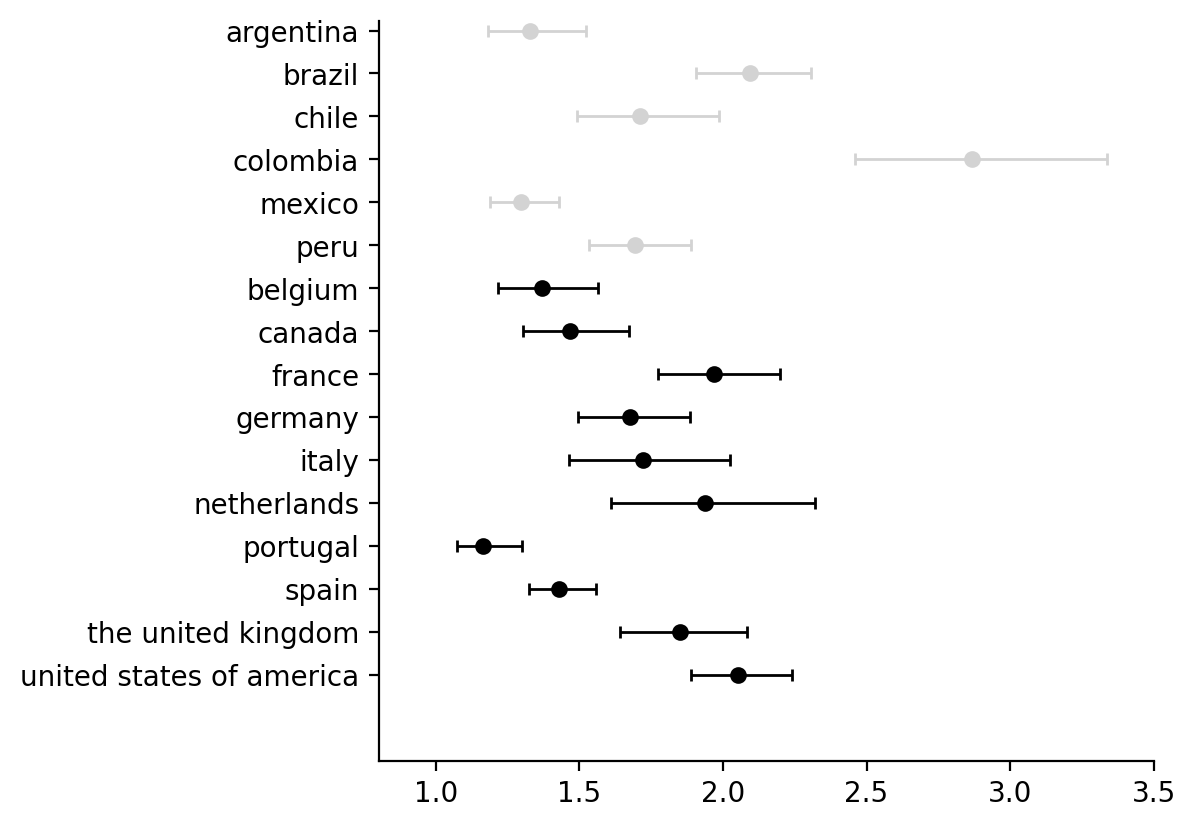

In [113]:
# for presentation
fig = plt.figure(figsize = [5, 4.8])  #, dpi = 300
ax1 = fig.add_subplot()

df_ = df_stats_countries.copy().loc[lambda d: d['var']=='R0'][::-1]


df_['color'] = ['lightgrey' if (who_region=='AMRO')&(country!='united states of america')&(country!='canada') else 'k' for country, who_region in zip(df_.country,df_.who_region)]
df_ = df_.sort_values('color')

df_['Source'] = df_['country']
df_['Source_y'] = [(1.5*i+1)/df_.shape[0] for i in range(df_.shape[0])]

for clr_ in df_['color'].drop_duplicates().values:
    df__ = df_.loc[lambda d: d['color']==clr_]
    ax1.errorbar(x=list(df__['median']), y=df__['Source_y'], 
                 xerr=[list(df__['median'] - df__['q2.5']), list(df__['q97.5'] - df__['median'])], color=clr_, capsize=2,
                 linestyle='None', linewidth=1, markersize=0)
    ax1.plot(list(df__['median']), df__['Source_y'], color=clr_, mfc=clr_, 
             linestyle='None', linewidth=1, marker="o", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = .8, right=3.5)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()

ax1.set_yticks(df_['Source_y'])
ax1.set_yticklabels(df_['Source'])
ax1.set_ylim(-2./df_.shape[0], np.max(df_['Source_y'])+.02)

plt.show()

In [114]:
df_stats_countries['SD'] = [(upper - lower) / 1.96 / 2 for lower, upper in zip(df_stats_countries['q2.5'], df_stats_countries['q97.5'])]
df_stats_countries

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,country,who_region,SD
0,r,NA,0.02373,0.01279,0.01965,0.02708,0.03449,0.01352,0.01986,0.02353,0.02736,0.03533,NaN,NaN,NaN,argentina,AMRO,0.005564
1,i0,NA,4.02451,2.82557,3.49772,4.34927,5.31067,2.86016,3.57439,3.99280,4.43533,5.37445,NaN,NaN,NaN,argentina,AMRO,0.641401
2,phi,NA,6.61832,3.41078,4.79159,7.18866,10.48350,3.66310,5.25063,6.38374,7.69078,10.99858,NaN,NaN,NaN,argentina,AMRO,1.871296
3,R0,NA,1.33422,1.16979,1.26241,1.37764,1.50811,1.18013,1.27276,1.32907,1.38963,1.52259,NaN,NaN,NaN,argentina,AMRO,0.087362
4,doubling_time,NA,31.04519,17.79070,22.84820,31.78500,47.05620,19.61745,25.33442,29.45195,34.90788,51.25706,NaN,NaN,NaN,argentina,AMRO,8.071329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,r,NA,0.06281,0.05467,0.05992,0.06552,0.07093,0.05485,0.05990,0.06272,0.06551,0.07125,NaN,NaN,NaN,united states of america,AMRO,0.004184
76,i0,NA,39.19466,31.39890,36.50560,41.91520,47.11920,31.67291,36.38458,39.05110,41.83763,47.46972,NaN,NaN,NaN,united states of america,AMRO,4.029798
77,phi,NA,8.04346,4.83256,6.48550,8.80910,11.65790,4.98253,6.77166,7.90520,9.17268,12.00764,NaN,NaN,NaN,united states of america,AMRO,1.792120
78,R0,NA,2.05521,1.88435,1.98568,2.10575,2.23348,1.88795,1.99212,2.05184,2.11238,2.24078,NaN,NaN,NaN,united states of america,AMRO,0.090008


### With AMRO countries

In [115]:
stan_code_meta_summary = """data {
  int<lower=1> J;  // number of studies with available data
  vector[J] mu_known;  // means of known studies
  vector<lower=0>[J] stderr_known;  // standard errors of known studies
}

parameters {
  real<lower=0> mu, tau_squared;
}

model {
  // Priors
  mu ~ normal(4, 8);  // weakly informative prior for the overall mean
  tau_squared ~ cauchy(0, 5);  // weakly informative prior for the between-study variability

  // Likelihood
  mu_known ~ normal(mu, sqrt(square(stderr_known) + tau_squared));
}

generated quantities {
  real mu_pred;

    {
        // Predict a future observation for a hypothetical new study
        mu_pred = normal_rng(mu, sqrt(tau_squared));
    }
}"""

basename = 'R0_meta_with_AMRO'
standirname = os.path.join(mainstandirname, basename)
if recalc_everything:
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]
        
    stan_code_file = os.path.join(standirname, 'fit_R0_meta.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_meta_summary)
        f.close()

    df_ = df_stats_countries.copy().loc[lambda d: d['var']=='R0'][::-1]
    
    stan_data = dict({
        'J': df_.shape[0],
        'mu_known': df_['mean'].values,
        'stderr_known': df_['SD'].values
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)
    
    def bash_file(stanscriptdir):
        return f"""#!/bin/bash
cwd=$(pwd)
cd {standistribdir_}
make -j4 {stanscriptdir}/fit_R0_meta
cd {stanscriptdir}
mkdir -p diagnostics
for i in {{1..4}}
do
    echo Running ${{i}}
    SEEDNUMBER=$((1+$i))
    ./fit_R0_meta \\
        method=sample num_samples={num_iterations} num_warmup={num_warmup} thin=1 save_warmup=0 adapt delta=0.98 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${{SEEDNUMBER}} \\
        id=$i \\
        data file=Data.json \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""            
    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=4000,
                       show_console=False, show_progress=True, chains = 4)
    fit.save_csvfiles(dir=standirname)

16:05:03 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_with_AMRO/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_with_AMRO/fit_R0_meta
16:06:07 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta_with_AMRO/fit_R0_meta
16:06:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:06:07 - cmdstanpy - INFO - CmdStan done processing.


In [116]:
idata_meta = az.from_cmdstanpy(posterior=fit)
df_meta_stats = get_stats(idata_meta.posterior, ['mu', 'tau_squared'])
df_meta_stats

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,mu,NA,1.71112,1.48466,1.63222,1.77727,1.94965,1.48079,1.63715,1.70952,1.78326,1.94703,9177.87241,8245.50153,1.00027
1,tau_squared,NA,0.19392,0.05623,0.09879,0.19307,0.38738,0.07524,0.12620,0.17139,0.23338,0.45044,8469.81694,8986.47687,1.00035


### Without AMRO countries

In [117]:
stan_code_meta_summary = """data {
  int<lower=1> J;  // number of studies with available data
  vector[J] mu_known;  // means of known studies
  vector<lower=0>[J] stderr_known;  // standard errors of known studies
}

parameters {
  real<lower=0> mu, tau_squared;
}

model {
  // Priors
  mu ~ normal(4, 8);  // weakly informative prior for the overall mean
  tau_squared ~ cauchy(0, 5);  // weakly informative prior for the between-study variability

  // Likelihood
  mu_known ~ normal(mu, sqrt(square(stderr_known) + tau_squared));
}

generated quantities {
  real mu_pred;

    {
        // Predict a future observation for a hypothetical new study
        mu_pred = normal_rng(mu, sqrt(tau_squared));
    }
}"""

basename = 'R0_meta'
standirname = os.path.join(mainstandirname, basename)
if recalc_everything:
    !rm {standirname}/*
    os.makedirs(standirname, exist_ok=True)
    stanscriptdir = '../Dropbox/'+standirname[9:]
        
    stan_code_file = os.path.join(standirname, 'fit_R0_meta.stan')
    with open(stan_code_file, "w+") as f:
        f.write(stan_code_meta_summary)
        f.close()

    df_ = df_stats_countries.copy().loc[lambda d: d['var']=='R0'][::-1]
    df_ = df_.loc[lambda d: ~((d.who_region=='AMRO')&(d.country!='united states of america')&(d.country!='canada'))]
    
    stan_data = dict({
        'J': df_.shape[0],
        'mu_known': df_['mean'].values,
        'stderr_known': df_['SD'].values
    })
    stan_data_file = os.path.join(standirname, 'Data.json')
    cmdstan.write_stan_json(stan_data_file, stan_data)
    
    def bash_file(stanscriptdir):
        return f"""#!/bin/bash
cwd=$(pwd)
cd {standistribdir_}
make -j4 {stanscriptdir}/fit_R0_meta
cd {stanscriptdir}
mkdir -p diagnostics
for i in {{1..4}}
do
    echo Running ${{i}}
    SEEDNUMBER=$((1+$i))
    ./fit_R0_meta \\
        method=sample num_samples={num_iterations} num_warmup={num_warmup} thin=1 save_warmup=0 adapt delta=0.98 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${{SEEDNUMBER}} \\
        id=$i \\
        data file=Data.json \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""            
    model = cmdstan.CmdStanModel(stan_file=stan_code_file)
    fit = model.sample(data=stan_data_file, seed = 1, iter_warmup=num_warmup, iter_sampling=4000,
                       show_console=False, show_progress=True, chains = 4)
    fit.save_csvfiles(dir=standirname)

16:06:08 - cmdstanpy - INFO - compiling stan file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta/fit_R0_meta.stan to exe file /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta/fit_R0_meta
16:07:12 - cmdstanpy - INFO - compiled model executable: /mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta/fit_R0_meta
16:07:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:07:12 - cmdstanpy - INFO - CmdStan done processing.
16:07:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/mnt/data/Dropbox/Taiwan_Backup/Monkeypox_2022/R0_meta/fit_R0_meta.stan', line 17, column 2 to column 66)
Consider re-running with show_console=True if the above output is unclear!


In [118]:
idata_meta = az.from_cmdstanpy(posterior=fit)
df_meta_stats = get_stats(idata_meta.posterior, ['mu', 'tau_squared'])
df_meta_stats

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,mu,NA,1.65737,1.40302,1.57942,1.73506,1.92027,1.40310,1.57858,1.65600,1.73453,1.92027,7926.92604,6757.29991,1.00040
1,tau_squared,NA,0.14960,0.02764,0.05622,0.13360,0.35656,0.04217,0.08051,0.11812,0.17848,0.44777,8031.75063,8459.73193,1.00004


In [119]:
df_cumcases_selection.columns

Index(['country', 'who_region', 'cases', 'peak_cases', 'peak_date',
       'peak_date_type', 'file'],
      dtype='object')

In [120]:
df_stats_countries.merge(df_cumcases_selection.loc[:, ['country', 'cases', 'peak_cases', 'peak_date']])

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,...,q97.5,ess_bulk,ess_tail,r_hat,country,who_region,SD,cases,peak_cases,peak_date
0,r,NA,0.02373,0.01279,0.01965,0.02708,0.03449,0.01352,0.01986,0.02353,...,0.03533,NaN,NaN,NaN,argentina,AMRO,0.005564,1037,18,2022-09-15
1,i0,NA,4.02451,2.82557,3.49772,4.34927,5.31067,2.86016,3.57439,3.99280,...,5.37445,NaN,NaN,NaN,argentina,AMRO,0.641401,1037,18,2022-09-15
2,phi,NA,6.61832,3.41078,4.79159,7.18866,10.48350,3.66310,5.25063,6.38374,...,10.99858,NaN,NaN,NaN,argentina,AMRO,1.871296,1037,18,2022-09-15
3,R0,NA,1.33422,1.16979,1.26241,1.37764,1.50811,1.18013,1.27276,1.32907,...,1.52259,NaN,NaN,NaN,argentina,AMRO,0.087362,1037,18,2022-09-15
4,doubling_time,NA,31.04519,17.79070,22.84820,31.78500,47.05620,19.61745,25.33442,29.45195,...,51.25706,NaN,NaN,NaN,argentina,AMRO,8.071329,1037,18,2022-09-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,r,NA,0.06281,0.05467,0.05992,0.06552,0.07093,0.05485,0.05990,0.06272,...,0.07125,NaN,NaN,NaN,united states of america,AMRO,0.004184,29000,530,2022-08-01
76,i0,NA,39.19466,31.39890,36.50560,41.91520,47.11920,31.67291,36.38458,39.05110,...,47.46972,NaN,NaN,NaN,united states of america,AMRO,4.029798,29000,530,2022-08-01
77,phi,NA,8.04346,4.83256,6.48550,8.80910,11.65790,4.98253,6.77166,7.90520,...,12.00764,NaN,NaN,NaN,united states of america,AMRO,1.792120,29000,530,2022-08-01
78,R0,NA,2.05521,1.88435,1.98568,2.10575,2.23348,1.88795,1.99212,2.05184,...,2.24078,NaN,NaN,NaN,united states of america,AMRO,0.090008,29000,530,2022-08-01


/tmp/ipykernel_5728/4142081989.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(df_['Source'].values)


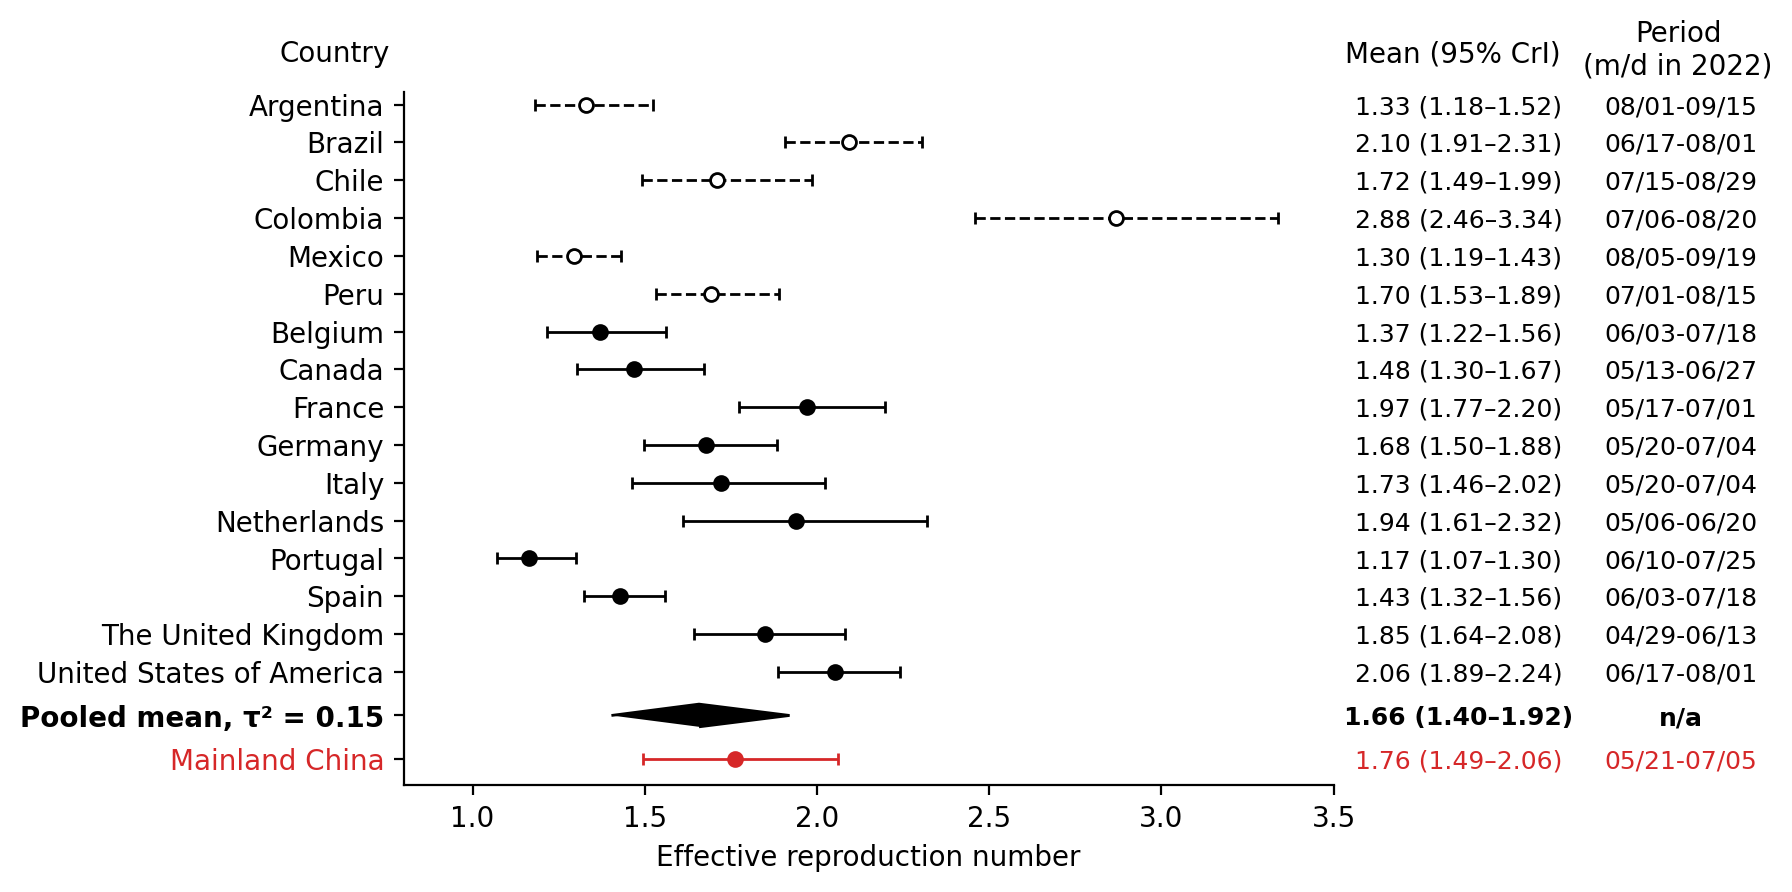

In [121]:
# for presentation
fig = plt.figure(figsize = [6, 4.5])  #, dpi = 300
ax1 = fig.add_subplot()

df_ = df_stats_countries.copy().merge(df_cumcases_selection.loc[:, ['country', 'cases', 'peak_cases', 'peak_date']]).loc[lambda d: d['var']=='R0'][::-1]

df_['color'] = ['lightgrey' if (who_region=='AMRO')&(country!='united states of america')&(country!='canada') else 'k' for country, who_region in zip(df_.country,df_.who_region)]
df_ = df_.sort_values('color')

df_['Source'] = [x.title().replace(' Of ', ' of ') for x in df_['country']]
# df_['Source'] = [country + ' [' + who_region + ']' for country, who_region in zip(df_['country'],df_['who_region'])]
df_['Source_y'] = [(i+1)/df_.shape[0] for i in range(df_.shape[0])]

for clr_ in df_['color'].drop_duplicates().values:
    df__ = df_.loc[lambda d: d['color']==clr_]
    lsty = 'dashed' if clr_=='lightgrey' else 'solid'
    eb1 = ax1.errorbar(x=list(df__['median']), y=df__['Source_y'], 
                 xerr=[list(df__['median'] - df__['q2.5']), list(df__['q97.5'] - df__['median'])], color='k', capsize=2,
                 linestyle='None', linewidth=1, markersize=0)
    if clr_=='lightgrey':
        eb1[-1][0].set_linestyle('--')
        clr0_ = 'w'
    else:
        clr0_ = 'k'
    ax1.plot(list(df__['median']), df__['Source_y'], color='k', mfc=clr0_, 
             linestyle='None', linewidth=1, marker="o", ms=5)

# Pooled mean
mean_meta = df_meta_stats.loc[lambda d: d['var']=='mu', 'mean'].values[0]
lower_meta = df_meta_stats.loc[lambda d: d['var']=='mu', 'q2.5'].values[0]
upper_meta = df_meta_stats.loc[lambda d: d['var']=='mu', 'q97.5'].values[0]
τsqr_meta = df_meta_stats.loc[lambda d: d['var']=='tau_squared', 'mean'].values[0]
y_ = -0.15/df_.shape[0]
h_ = 0.3/df_.shape[0]
from matplotlib.patches import Polygon
pts = np.array([[lower_meta, y_], [mean_meta,y_+h_], [upper_meta, y_], [mean_meta, y_-h_], [lower_meta, y_]])
p = Polygon(pts, closed=False, color='k')
ax1.add_patch(p)

## current study
df__ = df_stats_chn_method2.copy().loc[lambda d: d['var']=='R0']
df__['Source'] = 'Mainland China'

y__ = -1.3/df_.shape[0]
clr_chn_ = 'C3'

ax1.errorbar(x=list(df__['mean']), y=y__, 
             xerr=[list(df__['mean'] - df__['q2.5']), list(df__['q97.5'] - df__['mean'])], color=clr_chn_, capsize=2,
             linestyle='None', linewidth=1, markersize=0)
ax1.plot(list(df__['mean']), y__, color=clr_chn_, linestyle='None', linewidth=1, marker="o", ms=5)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(left = .8, right=3.5)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()

# ax1.set_yticks(df_['Source_y'])
ax1.set_yticklabels(df_['Source'].values)
ax1.set_ylim(-2/df_.shape[0], np.max(df_['Source_y'])+.02)
ax1.set_xlabel("Effective reproduction number")
ax1.set_yticks(np.r_[df_['Source_y'], y_, [y__]])
ax1.set_yticklabels(np.r_[df_['Source'], [f'Pooled mean, τ² = {τsqr_meta:.2f}'], df__['Source']] )

ax2 = ax1.secondary_yaxis("right")
ax2.set_yticks(ax1.get_yticks())
ax2.spines['right'].set_visible(False)
ax2.tick_params(length=0)
df_['label'] = [f"{mu:.2f} ({mu_lower:.2f}–{mu_upper:.2f})" for mu, mu_lower, mu_upper in zip(df_['mean'], df_['q2.5'], df_['q97.5'])]
df__['label'] = [f"{mu:.2f} ({mu_lower:.2f}–{mu_upper:.2f})" for mu, mu_lower, mu_upper in zip(df__['mean'], df__['q2.5'], df__['q97.5'])]
ax2.set_yticklabels(np.r_[df_['label'], [f'{mean_meta:.2f} ({lower_meta:.2f}–{upper_meta:.2f})'], df__['label']], ha='center', fontsize=9)
ax2.yaxis.set_tick_params(pad=45)

ax3 = ax1.secondary_yaxis("right")
ax3.set_yticks(ax1.get_yticks())
ax3.spines['right'].set_visible(False)
ax3.tick_params(length=0)
df_['label2'] = [f"{(peak_date-pd.DateOffset(days=45)).strftime('%m/%d')}-{peak_date.strftime('%m/%d')}" for peak_date in df_['peak_date']]
label_chn = f"{date_lower.strftime('%m/%d')}-{date_upper.strftime('%m/%d')}"
ax3.set_yticklabels(np.r_[df_['label2'], ['n/a', label_chn]], ha='center', fontsize=9)
ax3.yaxis.set_tick_params(pad=125)

# [label.set_color('lightgrey') if idx>=len(ax1.get_yticklabels())-2-len(df_.loc[lambda d: d['color']=='lightgrey']) else None for idx,label in enumerate(ax1.get_yticklabels())]
# [label.set_color('lightgrey') if idx>=len(ax1.get_yticklabels())-2-len(df_.loc[lambda d: d['color']=='lightgrey']) else None for idx,label in enumerate(ax2.get_yticklabels())]

[label.set_fontweight('bold') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
[label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
[label2.set_fontweight('bold') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax3.get_yticklabels())]

[label.set_color('k') if 'Pool' in label.get_text() else None for label in ax1.get_yticklabels()]
[label2.set_color('k') if 'Pool' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]

[label.set_color(clr_chn_) if 'China' in label.get_text() else None for label in ax1.get_yticklabels()]
[label2.set_color(clr_chn_) if 'China' in label.get_text() else None for label, label2 in zip(ax1.get_yticklabels(),ax2.get_yticklabels())]
[label3.set_color(clr_chn_) if 'China' in label.get_text() else None for label, label3 in zip(ax1.get_yticklabels(),ax3.get_yticklabels())]

plt.text(.44, 1.07, 'Country', horizontalalignment='left', fontsize=10)
plt.text(4.16, 1.07, 'Mean (95% CrI)', horizontalalignment='right', fontsize=10)
plt.text(4.5, 1.05, 'Period\n(m/d in 2022)', horizontalalignment='center', fontsize=10)

plt.rcParams["axes.labelweight"] = "bold"
if save_figures:
    plt.savefig("../../figures/fig-R0_meta.pdf", format="pdf", bbox_inches="tight")

plt.show()